In [1]:
import sys
import shap
import numpy as np
import pandas as pd
from pathlib import Path

from IPython.display import display

main_path = Path().absolute().parent
sys.path.append(str(main_path))
shap.initjs()

In [2]:
from fge.tree_builder import TreeBuilder
from CAhousing import build_model

results = build_model(seed=8, eta=0.3, max_depth=8, subsample=1.0, num_rounds=200)

[0]	test-rmse:1.43881
[20]	test-rmse:0.47593
[40]	test-rmse:0.46441
[60]	test-rmse:0.46037
[80]	test-rmse:0.45844
[100]	test-rmse:0.45819
[120]	test-rmse:0.45695
[140]	test-rmse:0.45686
[160]	test-rmse:0.45652
[180]	test-rmse:0.45721
[199]	test-rmse:0.45819
# of train data: 18576
# of test data: 2064
R2 square: 0.8452950327375699


calculate all shap values + shape interaction values

In [3]:
model = results['model']
X_train, y_train = results['train']
X_test, y_test = results['test']

explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test)
shap_interaction_values = explainer.shap_interaction_values(X_test)

## Stats in shap interaction values

In [4]:
feature_names = X_test.columns
n_samples, n_features, _ = shap_interaction_values.shape
r_diag, c_diag = np.diag_indices(n_features)
main_eff = np.abs(shap_interaction_values[:, r_diag, c_diag])
r_tril, c_tril = np.tril_indices(n_features, -1)
inter_eff = np.abs(shap_interaction_values[:, r_tril, c_tril])
print('The stats on main effect on each features')
df_main_eff = pd.DataFrame(main_eff, columns=feature_names)
display(df_main_eff.describe().round(3))

print('The stats on interaction effect on each combination of features')
df_inter_eff = pd.DataFrame(inter_eff, columns=[f'{feature_names[r]}+{feature_names[c]}' for r, c in zip(r_tril, c_tril)]).describe().T
df_inter_eff['bigger_than_two_main_effects(#)'] = 0
sv = np.abs(shap_values.values)
siv = np.abs(shap_interaction_values)
details = {}
for r, c in zip(r_tril, c_tril):
    f_name = f'{feature_names[r]}+{feature_names[c]}'
    criteria = (sv[:, r] + sv[:, c] > siv[:, r, c])
    df_inter_eff.loc[f_name, 'bigger_than_two_main_effects(#)'] = criteria.sum()
    details[f_name] = {
        feature_names[r]: shap_values.values[~criteria, r], 
        feature_names[c]: shap_values.values[~criteria, c], 
        f_name: shap_interaction_values[~criteria, r, c]
    }

df_inter_eff['bigger_than_two_main_effects(%)'] = df_inter_eff['bigger_than_two_main_effects(#)'] *100 / n_samples
df_inter_eff.drop(columns=['count'], inplace=True)
display(df_inter_eff.round(3))

The stats on main effect on each features


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,2064.000,2064.000,2064.000,2064.000,2064.000,2064.000,2064.000,2064.000
mean,0.445,0.059,0.108,0.024,0.022,0.222,0.348,0.415
std,0.435,0.042,0.075,0.023,0.028,0.180,0.235,0.246
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.156,0.029,0.059,0.008,0.006,0.085,0.169,0.193
50%,0.358,0.051,0.100,0.018,0.014,0.188,0.306,0.425
75%,0.583,0.078,0.139,0.033,0.028,0.301,0.468,0.595
max,2.538,0.313,0.546,0.224,0.426,0.882,1.160,1.156


The stats on interaction effect on each combination of features


,mean,std,min,25%,50%,75%,max,bigger_than_two_main_effects(#),bigger_than_two_main_effects(%)
HouseAge+MedInc,0.028,0.035,0.0,0.007,0.016,0.034,0.277,2055,99.564
AveRooms+MedInc,0.033,0.033,0.0,0.012,0.025,0.044,0.413,2059,99.758
AveRooms+HouseAge,0.011,0.012,0.0,0.004,0.008,0.015,0.139,2049,99.273
AveBedrms+MedInc,0.016,0.019,0.0,0.005,0.011,0.021,0.290,2059,99.758
AveBedrms+HouseAge,0.007,0.009,0.0,0.002,0.004,0.009,0.114,2050,99.322
AveBedrms+AveRooms,0.014,0.017,0.0,0.004,0.008,0.016,0.127,2047,99.176
Population+MedInc,0.013,0.020,0.0,0.003,0.008,0.016,0.441,2059,99.758
Population+HouseAge,0.007,0.009,0.0,0.002,0.004,0.008,0.147,2042,98.934
Population+AveRooms,0.010,0.014,0.0,0.003,0.006,0.011,0.227,2051,99.370
Population+AveBedrms,0.006,0.007,0.0,0.002,0.004,0.008,0.077,2040,98.837


## Building a feature tree

In [5]:
tree_builder = TreeBuilder()
# magnitude: whether to absolute the shap interaction values to store into values(not related with scores) 
# = only look at the size of values
magnitude = False 
top_n = 3
# check the difference with average shape values if using `magnitude` option

display(pd.DataFrame(shap_values.values.mean(0)[:, np.newaxis].T, columns=X_test.columns))
print(f'Sum of all averaged global shap values: {shap_values.values.mean(0).sum()}')

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,-0.004956,0.005497,-0.024868,0.007195,0.001947,0.011714,-0.046797,0.0223


Sum of all averaged global shap values: -0.027967434376478195


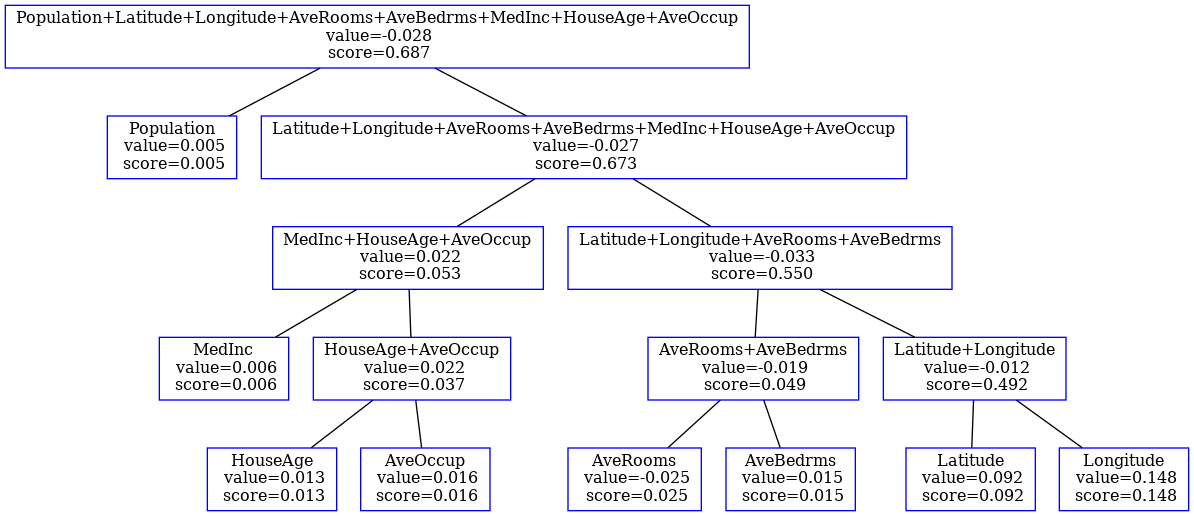

In [6]:
# global tree with 'base' method
nodes = tree_builder.build('base', 
    shap_interactions=shap_interaction_values, feature_names=X_test.columns, top_n=top_n, magnitude=magnitude)
tree_builder.show_tree(nodes)

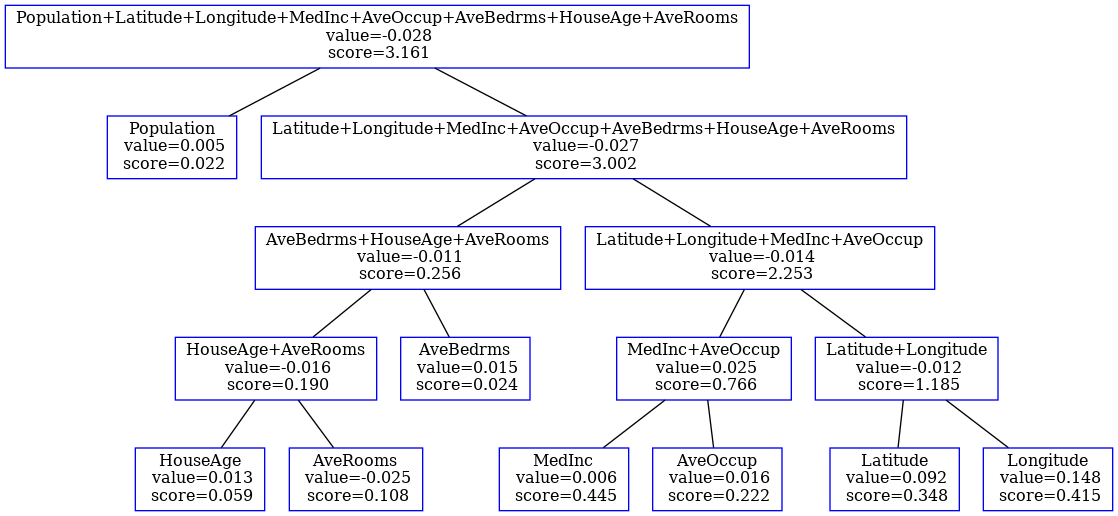

In [7]:
# global tree with 'abs' method
nodes = tree_builder.build('abs', 
    shap_interactions=shap_interaction_values, feature_names=X_test.columns, top_n=top_n, magnitude=magnitude)
tree_builder.show_tree(nodes)

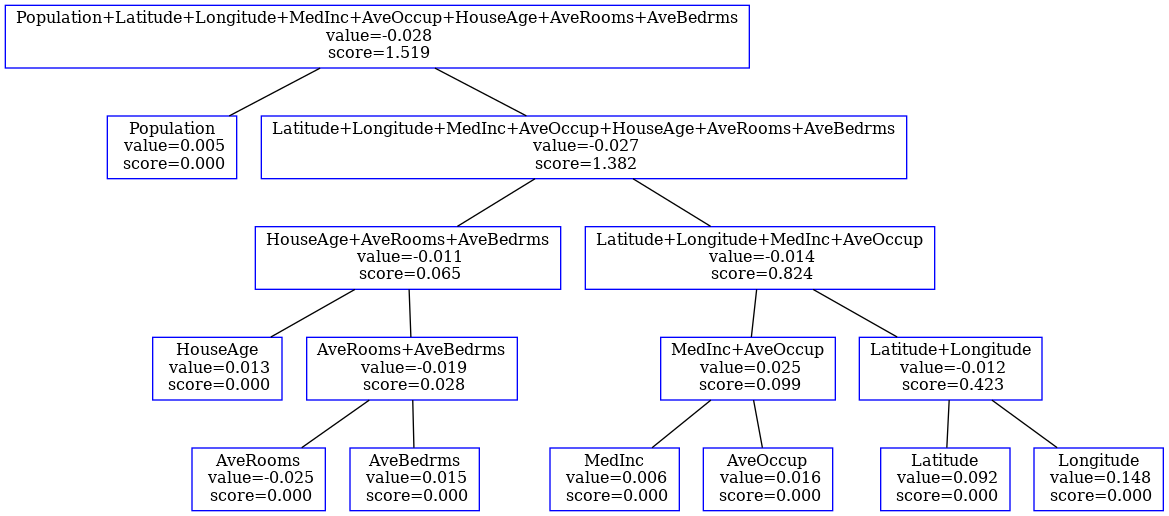

In [8]:
# global tree with 'abs_interaction' method
nodes = tree_builder.build('abs_interaction', 
    shap_interactions=shap_interaction_values, feature_names=X_test.columns, top_n=top_n, magnitude=magnitude)
tree_builder.show_tree(nodes)

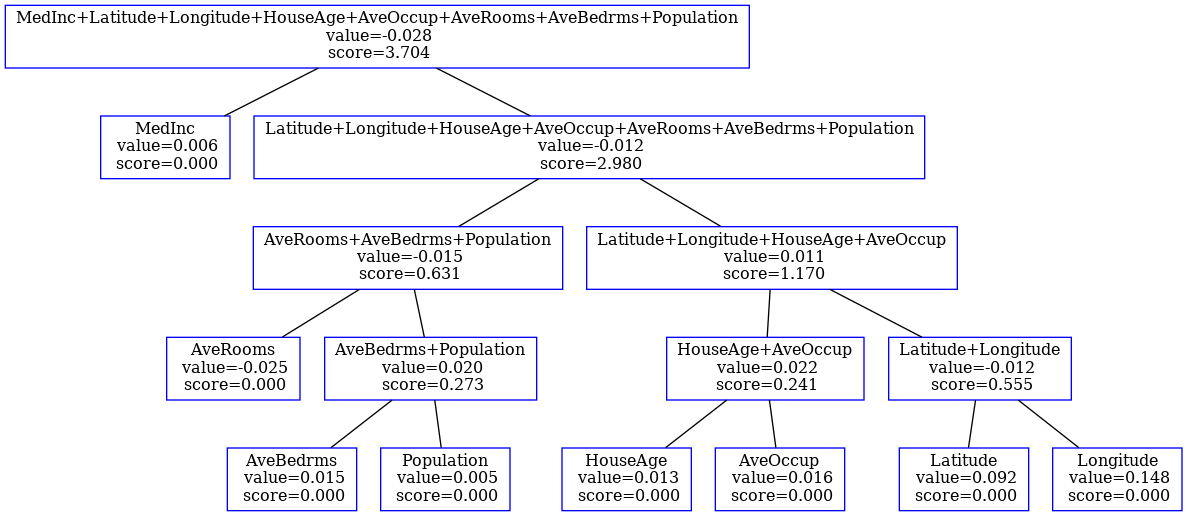

In [9]:
# global tree with 'ratio' method
nodes = tree_builder.build('ratio', 
    shap_interactions=shap_interaction_values, feature_names=X_test.columns, top_n=top_n, magnitude=magnitude)
tree_builder.show_tree(nodes)

with magnitude = True

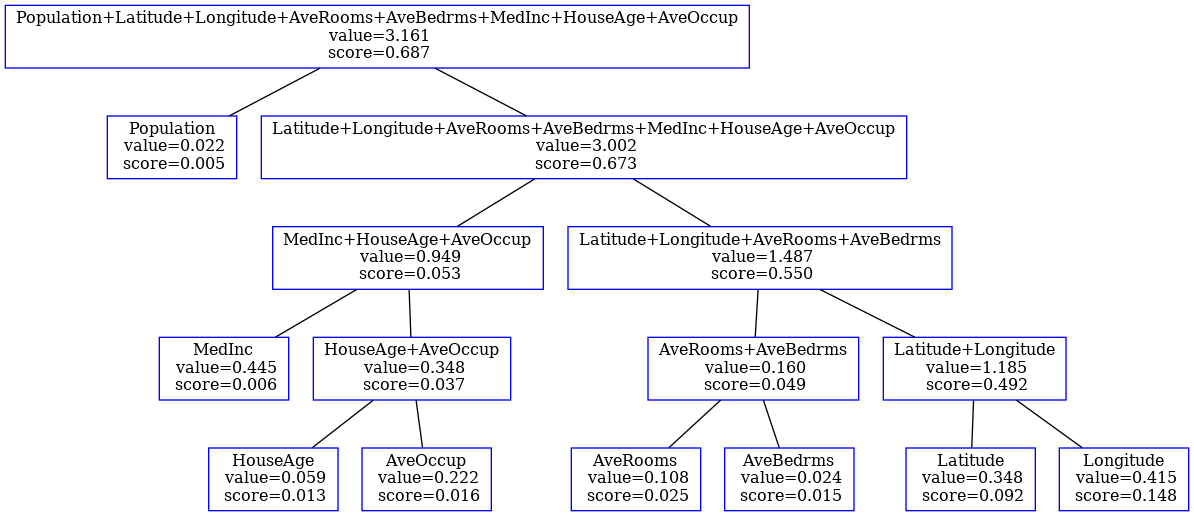

In [10]:
# magnitude: whether to absolute the shap interaction values to store into values(not related with scores) 
# = only look at the size of values
magnitude = True

# global tree with 'base' method(magnitude=True)
nodes = tree_builder.build('base', 
    shap_interactions=shap_interaction_values, feature_names=X_test.columns, top_n=top_n, magnitude=magnitude)
tree_builder.show_tree(nodes)

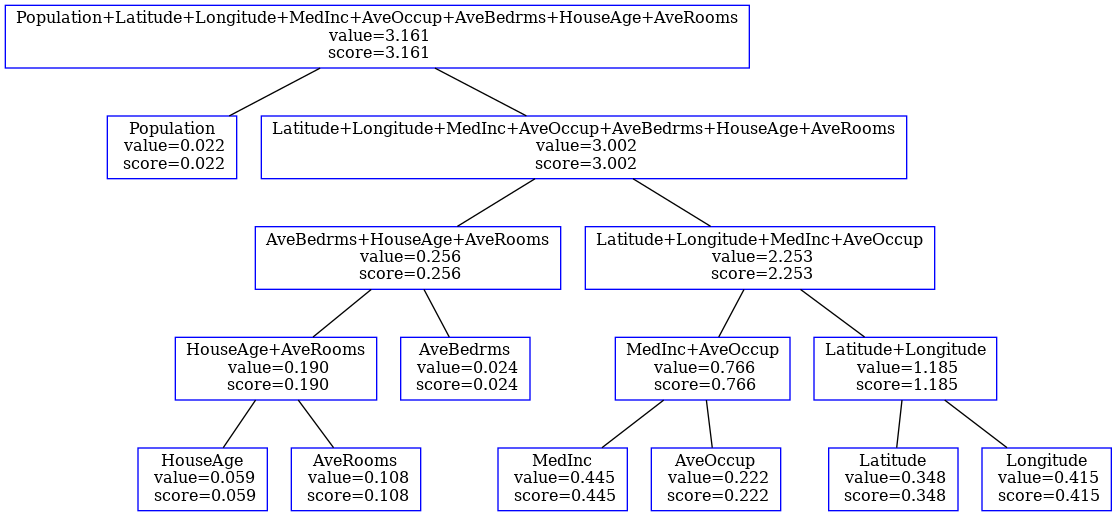

In [11]:
# global tree with 'abs' method(magnitude=True)
nodes = tree_builder.build('abs', 
    shap_interactions=shap_interaction_values, feature_names=X_test.columns, top_n=top_n, magnitude=magnitude)
tree_builder.show_tree(nodes)

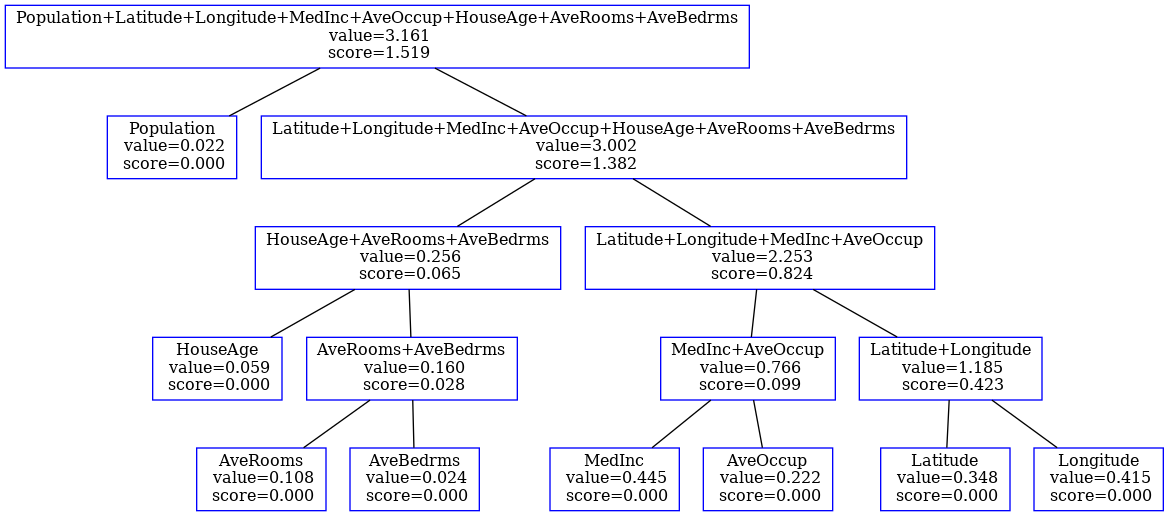

In [12]:
# global tree with 'abs_interaction' method(magnitude=True)
nodes = tree_builder.build('abs_interaction', 
    shap_interactions=shap_interaction_values, feature_names=X_test.columns, top_n=top_n, magnitude=magnitude)
tree_builder.show_tree(nodes)

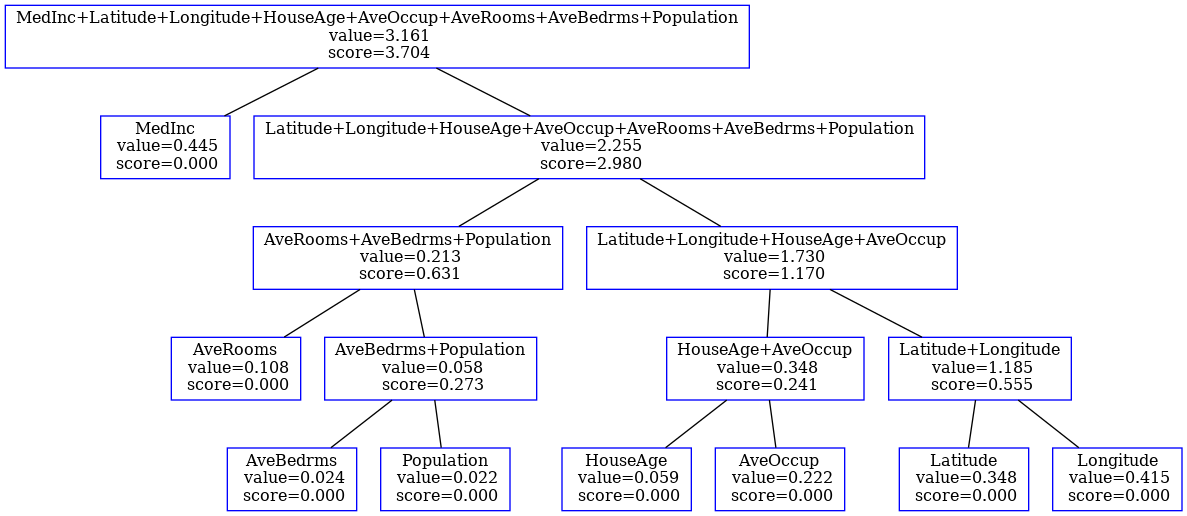

In [13]:
# global tree with 'ratio' method(magnitude=True)
nodes = tree_builder.build('ratio', 
    shap_interactions=shap_interaction_values, feature_names=X_test.columns, top_n=top_n, magnitude=magnitude)
tree_builder.show_tree(nodes)

Comparing existed shap values interpretation

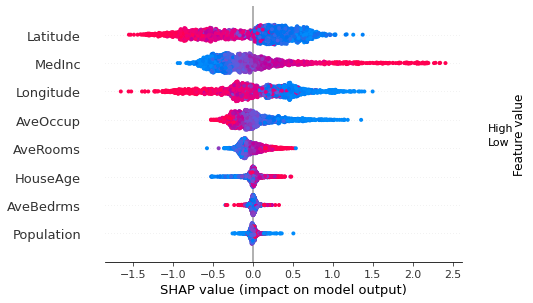

In [18]:
shap.summary_plot(shap_values)

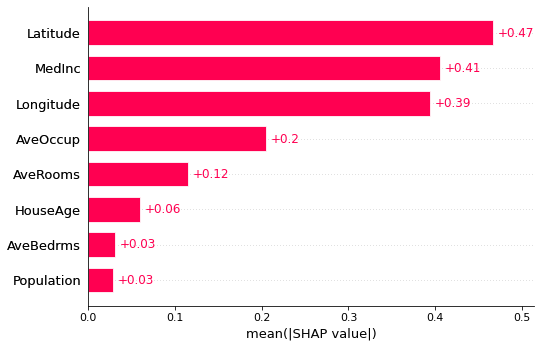

In [19]:
shap.plots.bar(shap_values)

In [24]:
shap.force_plot(explainer.expected_value, shap_values.values, X_test)

---

# Polynomial performance decrease to select trees

In [5]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score, accuracy_score
from sklearn.preprocessing import PolynomialFeatures
from collections import defaultdict

class PolyFitter():
    def __init__(self, task_type: str):
        self.task_type = task_type
        self.task_dict = {
            'reg': (LinearRegression, r2_score),
            'binary': (LogisticRegression, accuracy_score),
        }
        self.task_model, self.task_metric = self.task_dict[task_type]
        self.reset_records()

    def reset_records(self):
        self.records = defaultdict(dict)

    # def add_selective_interactions(self, X_original, interaction_dict, cut_off_level=1):
    #     X = X_original.copy()
    #     for curr_level in range(1, cut_off_level + 1):
    #         for interaction in interaction_dict[curr_level]:
    #             feature_names = interaction.split("+")
    #             X[interaction] = 1
    #             for feature in feature_names:
    #                 X[interaction] *= X[feature]
    #     return X

    def add_selective_interactions(self, X_original, interaction_dict, cut_off_level=1):
        X = X_original.copy()
        for curr_level in range(1, cut_off_level + 1):
            for interaction in interaction_dict[curr_level]:
                feature_names = interaction.split("+")
                X[interaction] = 1
                for feature in feature_names:
                    X[interaction] *= X[feature]
        return X

    def get_selective_polynomial_features(self, X_train, X_test, interaction_dict, cut_off_level=1):
        X_train_selective_polynomial = self.add_selective_interactions(X_train, interaction_dict, cut_off_level)
        X_test_selective_polynomial = self.add_selective_interactions(X_test, interaction_dict, cut_off_level)
        return X_train_selective_polynomial, X_test_selective_polynomial

    def get_full_polynomial_features(self, X_train_original, X_test_original):
        X_train, X_test = X_train_original.copy(), X_test_original.copy()
        poly = PolynomialFeatures(X_train.shape[1], interaction_only=True, include_bias=False)
        X_train_polynomial, X_test_polynomial = poly.fit_transform(X_train), poly.fit_transform(X_test)
        return X_train_polynomial, X_test_polynomial

    def get_polynomial_model_performance(self, X_train, y_train, X_test, y_test):
        poly_regression_model = self.task_model()
        poly_regression_model.fit(X_train, y_train)
        y_pred = poly_regression_model.predict(X_test)
        return self.task_metric(y_test, y_pred)

    def fit_full(self, dataset):
        X_train, X_test, y_train, y_test = dataset['X_train'], dataset['X_test'], dataset['y_train'], dataset['y_test']
        X_train_full, X_test_full = self.get_full_polynomial_features(X_train, X_test)
        self.records['full']['num_params'] = X_train_full.shape[1]
        full_performance = self.get_polynomial_model_performance(X_train_full, y_train, X_test_full, y_test)
        self.records['full']['performance'] = full_performance
        
    def fit_selected(self, dataset, interaction_dict, cut_off_level):
        X_train, X_test, y_train, y_test = dataset['X_train'], dataset['X_test'], dataset['y_train'], dataset['y_test']
        X_train_selected, X_test_selected = self.get_selective_polynomial_features(X_train, X_test, interaction_dict, cut_off_level)
        self.records['selected']['num_params'] = X_train_selected.shape[1]
        selected_performance = self.get_polynomial_model_performance(X_train_selected, y_train, X_test_selected, y_test)
        self.records['selected']['performance'] = selected_performance

    def get_performance_reduction(self, dataset, interaction_dict, cut_off_level):
        """
        performance decres: (0, performance gap)
        """
        assert self.records.get('full') is not None, 'Must run `fit_full` at first time'
        self.fit_selected(dataset, interaction_dict, cut_off_level)
        return max(self.records['full']['performance'] - self.records['selected']['performance'], 0)

In [25]:
import pygad

polyfitter = PolyFitter(task_type='reg')

def fitness_func(solution, solution_idx, polyfitter, ):
    return 

In [ ]:
dataset = {'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test}
interaction_dict = {1}
cut_off_level = 1
polyfitter.fit_full(dataset)

In [28]:
function_inputs = [4, -2, 3.5, 5, -11, -4.7] # Function inputs.
desired_output = 44 # Function output.

def fitness_func(solution, solution_idx):
    print(solution, type(solution))
    output = np.sum(solution*function_inputs)
    fitness = 1.0 / np.abs(output - desired_output)
    return fitness

In [29]:
num_generations = 50
num_parents_mating = 4

fitness_function = fitness_func

sol_per_pop = 8
num_genes = len(function_inputs)

init_range_low = -2
init_range_high = 5

parent_selection_type = "sss"
keep_parents = 1

crossover_type = "single_point"

mutation_type = "random"
mutation_percent_genes = 10

ga_instance = pygad.GA(
    num_generations=num_generations,
    num_parents_mating=num_parents_mating,
    fitness_func=fitness_function,
    sol_per_pop=sol_per_pop,
    num_genes=num_genes,
    init_range_low=init_range_low,
    init_range_high=init_range_high,
    parent_selection_type=parent_selection_type,
    keep_parents=keep_parents,
    crossover_type=crossover_type,
    mutation_type=mutation_type,
    mutation_percent_genes=mutation_percent_genes
)
ga_instance.run()

[ 0.80837177 -0.93853705  4.57337099 -0.89397475  4.51423749  0.86075383] <class 'numpy.ndarray'>
[-1.23768241  0.93030906 -0.34910798 -1.03180063 -1.46328865  1.21049676] <class 'numpy.ndarray'>
[ 2.99769201  3.34965777 -1.75504668 -0.2168495   1.24211983  4.30389389] <class 'numpy.ndarray'>
[ 4.38269932 -0.11442791 -0.20146778  4.01032109  3.49964565 -0.85509088] <class 'numpy.ndarray'>
[ 2.64815042  0.39979379 -1.15970583  2.78552759  1.43678262  4.46421259] <class 'numpy.ndarray'>
[-0.28704546  1.45617509 -1.58988899  1.61974362  3.27235676  1.66222509] <class 'numpy.ndarray'>
[ 0.65200879  1.35756396 -0.44196695  0.26990326  3.09660262 -1.86820226] <class 'numpy.ndarray'>
[ 0.02755075  0.11802901  0.01202083  4.54576396  3.8581202  -0.95828931] <class 'numpy.ndarray'>
[-1.23768241  0.93030906 -0.34910798 -0.75130997 -1.46328865  1.21049676] <class 'numpy.ndarray'>
[ 0.02755075  0.11802901  0.01515749  4.54576396  3.8581202  -0.95828931] <class 'numpy.ndarray'>
[ 0.02755075  0.1180

The percentage of genes to mutate (mutation_percent_genes=10) resutled in selecting (0) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).
If you do not want to mutate any gene, please set mutation_type=None.


In [14]:
from anytree import Node, RenderTree, LevelGroupOrderIter

tree_builder = TreeBuilder()
magnitude = False 
top_n = 3
feature_names = X_train.columns
g_fn = tree_builder.score_methods['abs']
shap_interactions = shap_interaction_values

# 
if shap_interactions.ndim == 3:
    # ndim == 3 case: global tree
    build_global = True
    siv = shap_interactions.mean(0) if not magnitude else np.abs(shap_interactions).mean(0)
elif shap_interactions.ndim == 2:
    # ndim == 2 case: single tree
    build_global = False
    siv = shap_interactions  if not magnitude else np.abs(shap_interactions)

siv_scores = g_fn(shap_interactions, build_global)

In [15]:
r_diag, c_diag = np.diag_indices(len(feature_names))
main_effect = siv[r_diag, c_diag]
main_scores = siv_scores[r_diag, c_diag]

nodes = {}
scores = {}
values = {}
done = set() # check need to run it or pass at the next time

for i, name in enumerate(feature_names):
    nodes[i] = Node(name=name, parent=None, value=main_effect[i], score=main_scores[i])

In [17]:
nodes_to_run = [k for k in nodes.keys() if k not in done]
nodes_to_run

[0, 1, 2, 3, 4, 5, 6, 7]

In [ ]:
num_generations = 50  # Number of generations
num_parents_mating = 4  # Number of solutions to be selected as parents

sol_per_pop = 8
num_genes = len(function_inputs)

init_range_low = 1
init_range_high = 5

parent_selection_type = "sss"
keep_parents = 1

crossover_type = "single_point"

mutation_type = "random"
mutation_percent_genes = 10

In [ ]:
ga_instance = pygad.GA()


In [ ]:
model = results['model']
X_train, y_train = results['train']
X_test, y_test = results['test']
feature_names = X_train.columns

explainer = shap.TreeExplainer(model)
train_sv = explainer(X_train)
test_sv = explainer(X_test)
train_siv = explainer.shap_interaction_values(X_train)
test_siv = explainer.shap_interaction_values(X_test)

tree_builder = TreeBuilder()
# magnitude: whether to absolute the shap interaction values to store into values(not related with scores) 
# = only look at the size of values
magnitude = False 

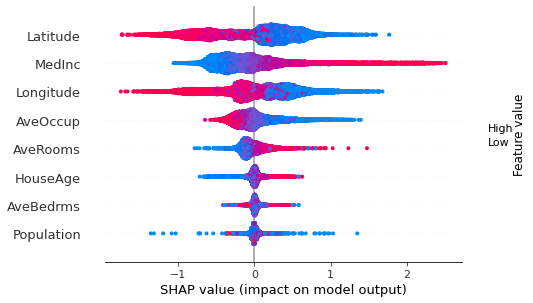

In [ ]:
shap.summary_plot(train_sv)

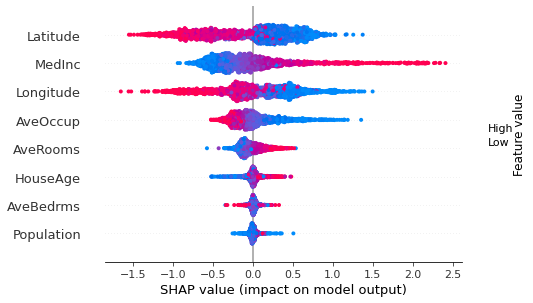

In [ ]:
shap.summary_plot(test_sv)

## Interpretations between Trainset & Testset

In [ ]:
import scipy.stats as stats

In [ ]:
top_n = 1
nodes = tree_builder.build('base', 
    shap_interactions=train_siv, feature_names=feature_names, top_n=top_n, magnitude=magnitude)
tree_builder

Population+AveOccup+HouseAge+AveBedrms+AveRooms+MedInc+Latitude+Longitude(v=0.0000, s=0.6807)
├── Population(v=0.0045, s=0.0045)
└── AveOccup+HouseAge+AveBedrms+AveRooms+MedInc+Latitude+Longitude(v=0.0024, s=0.6682)
    ├── AveOccup(v=0.0138, s=0.0138)
    └── HouseAge+AveBedrms+AveRooms+MedInc+Latitude+Longitude(v=-0.0079, s=0.6301)
        ├── HouseAge(v=0.0125, s=0.0125)
        └── AveBedrms+AveRooms+MedInc+Latitude+Longitude(v=-0.0138, s=0.5981)
            ├── AveBedrms(v=0.0155, s=0.0155)
            └── AveRooms+MedInc+Latitude+Longitude(v=-0.0120, s=0.5601)
                ├── AveRooms(v=-0.0259, s=0.0259)
                └── MedInc+Latitude+Longitude(v=0.0037, s=0.5145)
                    ├── MedInc(v=0.0212, s=0.0212)
                    └── Latitude+Longitude(v=0.0025, s=0.4732)
                        ├── Latitude(v=0.0922, s=0.0922)
                        └── Longitude(v=0.1456, s=0.1456)

In [ ]:
tree_builder.levels

{0: ['Population+AveOccup+HouseAge+AveBedrms+AveRooms+MedInc+Latitude+Longitude'],
 1: ['Population',
  'AveOccup+HouseAge+AveBedrms+AveRooms+MedInc+Latitude+Longitude'],
 2: ['AveOccup', 'HouseAge+AveBedrms+AveRooms+MedInc+Latitude+Longitude'],
 3: ['HouseAge', 'AveBedrms+AveRooms+MedInc+Latitude+Longitude'],
 4: ['AveBedrms', 'AveRooms+MedInc+Latitude+Longitude'],
 5: ['AveRooms', 'MedInc+Latitude+Longitude'],
 6: ['MedInc', 'Latitude+Longitude'],
 7: ['Latitude', 'Longitude']}

In [ ]:
top_n = 2
nodes = tree_builder.build('base', 
    shap_interactions=test_siv, feature_names=feature_names, top_n=top_n, magnitude=magnitude)
tree_builder

Latitude+Longitude+AveRooms+AveBedrms+HouseAge+AveOccup+MedInc+Population(v=-0.0280, s=0.6874)
├── Latitude+Longitude+AveRooms+AveBedrms+HouseAge+AveOccup(v=-0.0092, s=0.6137)
│   ├── Latitude+Longitude+AveRooms+AveBedrms(v=-0.0326, s=0.5505)
│   │   ├── Latitude+Longitude(v=-0.0122, s=0.4920)
│   │   │   ├── Latitude(v=0.0922, s=0.0922)
│   │   │   └── Longitude(v=0.1477, s=0.1477)
│   │   └── AveRooms+AveBedrms(v=-0.0189, s=0.0493)
│   │       ├── AveRooms(v=-0.0250, s=0.0250)
│   │       └── AveBedrms(v=0.0152, s=0.0152)
│   └── HouseAge+AveOccup(v=0.0217, s=0.0372)
│       ├── HouseAge(v=0.0130, s=0.0130)
│       └── AveOccup(v=0.0165, s=0.0165)
└── MedInc+Population(v=0.0128, s=0.0128)
    ├── MedInc(v=0.0063, s=0.0063)
    └── Population(v=0.0052, s=0.0052)

In [ ]:
tree_builder.levels

{0: ['Latitude+Longitude+AveRooms+AveBedrms+HouseAge+AveOccup+MedInc+Population'],
 1: ['Latitude+Longitude+AveRooms+AveBedrms+HouseAge+AveOccup',
  'MedInc+Population'],
 2: ['Latitude+Longitude+AveRooms+AveBedrms',
  'HouseAge+AveOccup',
  'MedInc',
  'Population'],
 3: ['Latitude+Longitude', 'AveRooms+AveBedrms', 'HouseAge', 'AveOccup'],
 4: ['Latitude', 'Longitude', 'AveRooms', 'AveBedrms']}

In [ ]:
top_n = 1
nodes = tree_builder.build('abs', 
    shap_interactions=test_siv, feature_names=feature_names, top_n=top_n, magnitude=magnitude)
tree_builder

Population+AveBedrms+HouseAge+AveRooms+AveOccup+MedInc+Latitude+Longitude(v=-0.0280, s=3.1610)
├── Population(v=0.0052, s=0.0217)
└── AveBedrms+HouseAge+AveRooms+AveOccup+MedInc+Latitude+Longitude(v=-0.0266, s=3.0024)
    ├── AveBedrms(v=0.0152, s=0.0240)
    └── HouseAge+AveRooms+AveOccup+MedInc+Latitude+Longitude(v=-0.0263, s=2.8337)
        ├── HouseAge(v=0.0130, s=0.0587)
        └── AveRooms+AveOccup+MedInc+Latitude+Longitude(v=-0.0258, s=2.5537)
            ├── AveRooms(v=-0.0250, s=0.1082)
            └── AveOccup+MedInc+Latitude+Longitude(v=-0.0143, s=2.2535)
                ├── AveOccup(v=0.0165, s=0.2220)
                └── MedInc+Latitude+Longitude(v=-0.0285, s=1.8104)
                    ├── MedInc(v=0.0063, s=0.4452)
                    └── Latitude+Longitude(v=-0.0122, s=1.1855)
                        ├── Latitude(v=0.0922, s=0.3476)
                        └── Longitude(v=0.1477, s=0.4149)

In [ ]:
tree_builder.levels

{0: ['Population+AveOccup+HouseAge+AveBedrms+AveRooms+MedInc+Latitude+Longitude'],
 1: ['Population',
  'AveOccup+HouseAge+AveBedrms+AveRooms+MedInc+Latitude+Longitude'],
 2: ['AveOccup', 'HouseAge+AveBedrms+AveRooms+MedInc+Latitude+Longitude'],
 3: ['HouseAge', 'AveBedrms+AveRooms+MedInc+Latitude+Longitude'],
 4: ['AveBedrms', 'AveRooms+MedInc+Latitude+Longitude'],
 5: ['AveRooms', 'MedInc+Latitude+Longitude'],
 6: ['MedInc', 'Latitude+Longitude'],
 7: ['Latitude', 'Longitude']}

In [ ]:
X_train.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,18576.000000,18576.000000,18576.000000,18576.000000,18576.000000,18576.000000,18576.000000,18576.000000
mean,3.875129,28.663437,5.425682,1.095703,1426.969692,3.087023,35.628788,-119.569507
std,1.906943,12.580786,2.519066,0.483814,1136.535080,10.943855,2.136983,2.005468
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000
25%,2.562500,18.000000,4.437713,1.005576,788.000000,2.430165,33.930000,-121.800000
50%,3.538500,29.000000,5.229575,1.048744,1166.500000,2.820312,34.250000,-118.490000
75%,4.745350,37.000000,6.049193,1.099639,1724.000000,3.282273,37.720000,-118.007500
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000


In [ ]:
X_test.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,2064.000000,2064.000000,2064.000000,2064.000000,2064.000000,2064.000000,2064.000000,2064.000000
mean,3.830553,28.423934,5.458860,1.105428,1412.040213,2.923346,35.659525,-119.571478
std,1.834444,12.629438,2.026123,0.373115,1095.299865,0.877843,2.126973,1.986505
min,0.536000,1.000000,1.784530,0.545455,8.000000,1.089268,32.550000,-124.170000
25%,2.582800,18.000000,4.468819,1.008547,779.750000,2.428571,33.940000,-121.780000
50%,3.508600,28.000000,5.225560,1.049011,1164.000000,2.809053,34.285000,-118.520000
75%,4.722200,37.000000,6.068082,1.098482,1729.500000,3.281516,37.670000,-118.027500
max,15.000100,52.000000,34.571429,7.022321,16122.000000,18.444444,41.740000,-114.580000


In [ ]:
stats.ttest_1samp(X_train['AveOccup'], 20)

Ttest_1sampResult(statistic=-210.6327176935065, pvalue=0.0)

In [ ]:
comment_dict = {
    True: ('has differences', 'Reject H0, tase H1'), 
    False: ('has no differences', 'Cannot reject H0')
}
alpha = 0.05
c = 'AveOccup'
statistic, pvalue = stats.ttest_ind(X_train[c], X_test[c])
res = pvalue < alpha
# T-Test: see if mean is similar
print(f'Test for column: {c} between Trainset and Testset(alpha = {int(100 - alpha*100):d}%)')
print(f'  H0: Mean of column "{c}" in Trainset is same to Testset')
print(f'  H1: Mean of column "{c}" in Trainset is not same to Testset')
print(f'  F={statistic:.4f}, p={pvalue:.4f}')
print(f'  p < 0.05? {res} = {comment_dict[res][0]}, So, {comment_dict[res][1]}')

Test for column: AveOccup between Trainset and Testset(alpha = 95%)
  H0: Mean of column "AveOccup" in Trainset is same to Testset
  H1: Mean of column "AveOccup" in Trainset is not same to Testset
  F=0.6792, p=0.4970
  p < 0.05? False = has no differences, So, Cannot reject H0


In [ ]:
stats.ttest_ind(X_train[c], X_test[c])

Ttest_indResult(statistic=0.6792137543302748, pvalue=0.4970100506209739)

In [ ]:
X_train.describe() - X_test.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000
mean,0.044576,0.239503,-0.033179,-0.009725,14.929479,0.163677,-0.030738,0.001970
std,0.072499,-0.048652,0.492943,0.110699,41.235215,10.066012,0.010010,0.018963
min,-0.036100,0.000000,-0.938377,-0.212121,-5.000000,-0.396960,-0.010000,-0.180000
25%,-0.020300,0.000000,-0.031106,-0.002971,8.250000,0.001594,-0.010000,-0.020000
50%,0.029900,1.000000,0.004015,-0.000266,2.500000,0.011260,-0.035000,0.030000
75%,0.023150,0.000000,-0.018889,0.001157,-5.500000,0.000757,0.050000,0.020000
max,0.000000,0.000000,107.337662,27.044345,19560.000000,1224.888889,0.210000,0.270000


In [ ]:
X_train.describe() / X_test.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000
mean,1.011637,1.008426,0.993922,0.991202,1.010573,1.055989,0.999138,0.999984
std,1.039521,0.996148,1.243294,1.296688,1.037647,12.466759,1.004706,1.009546
min,0.932649,1.000000,0.474161,0.611111,0.375000,0.635572,0.999693,1.001450
25%,0.992140,1.000000,0.993039,0.997054,1.010580,1.000656,0.999705,1.000164
50%,1.008522,1.035714,1.000768,0.999746,1.002148,1.004008,0.998979,0.999747
75%,1.004902,1.000000,0.996887,1.001053,0.996820,1.000231,1.001327,0.999831
max,1.000000,1.000000,4.104808,4.851197,2.213249,67.409639,1.005031,0.997644
